In [1]:
#%pip install -r requirements.txt

import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

import seaborn as sns

In [74]:
interest_rate = pd.read_csv('./data/interest_rate.csv')
energy_price = pd.read_csv('./data/energy_price.csv')
cpi = pd.read_csv('./data/cpi.csv')

In [64]:
interest_rate.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term
0,AUS,7.177895,2000,1,5.66,5.00
1,AUS,6.957619,2000,2,5.80,5.48
2,AUS,6.570435,2000,3,5.89,5.50
3,AUS,6.264706,2000,4,6.04,5.72
4,AUS,6.465652,2000,5,6.31,5.98
...,...,...,...,...,...,...
995,USA,2.530000,2014,9,0.12,0.09
996,USA,2.300000,2014,10,0.12,0.09
997,USA,2.330000,2014,11,0.13,0.09
998,USA,2.210000,2014,12,0.15,0.12


In [67]:
cpi.head(1000)

,location,cpi-index,year,month
0,AUS,3.700000,1948,9
1,AUS,3.733333,1948,10
2,AUS,3.766667,1948,11
3,AUS,3.800000,1948,12
4,AUS,3.833333,1949,1
...,...,...,...,...
995,USA,174.100000,2000,11
996,USA,174.000000,2000,12
997,USA,175.100000,2001,1
998,USA,175.800000,2001,2


In [75]:
energy_price.head(1000)

,location,year,month,Thousand Dollars,Megawatthours,Count,Cents/kWh,Lagged 1 - Cents/kWh,Lagged 2 - Cents/kWh,Lagged 3 - Cents/kWh,Lagged 4 - Cents/kWh,Lagged 5 - Cents/kWh,Lagged 6 - Cents/kWh,Lagged 7 - Cents/kWh,Lagged 8 - Cents/kWh,Lagged 9 - Cents/kWh,Lagged 10 - Cents/kWh,Lagged 11 - Cents/kWh,Lagged 12 - Cents/kWh
0,USA,2021,8,"22,168,583","158,634,041","138,446,332",13.97,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77,14.92,15.42,15.46,15.95
1,USA,2021,7,"21,542,208","155,309,157","138,311,825",13.87,13.97,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77,14.92,15.42,15.46
2,USA,2021,6,"18,393,637","132,820,257","138,320,005",13.85,13.87,13.97,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77,14.92,15.42
3,USA,2021,5,"14,101,163","101,489,132","137,431,855",13.89,13.85,13.87,13.97,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77,14.92
4,USA,2021,4,"12,960,789","94,177,116","137,610,383",13.76,13.89,13.85,13.87,13.97,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,USA,1991,5,"5,478,459","67,266,873",.,8.14,8.32,8.38,8.41,8.37,8.32,7.95,7.81,7.70,7.78,8.01,8.03,8.38
364,USA,1991,4,"5,256,024","65,887,836",.,7.98,8.14,8.32,8.38,8.41,8.37,8.32,7.95,7.81,7.70,7.78,8.01,8.03
365,USA,1991,3,"5,750,968","73,862,548",.,7.79,7.98,8.14,8.32,8.38,8.41,8.37,8.32,7.95,7.81,7.70,7.78,8.01
366,USA,1991,2,"6,041,939","79,444,016",.,7.61,7.79,7.98,8.14,8.32,8.38,8.41,8.37,8.32,7.95,7.81,7.70,7.78


In [76]:
df = interest_rate.merge(cpi, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df.merge(energy_price, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df[[c for c in df.columns if not c.endswith('_delme')]]

In [77]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,Thousand Dollars,Megawatthours,Count,...,Lagged 3 - Cents/kWh,Lagged 4 - Cents/kWh,Lagged 5 - Cents/kWh,Lagged 6 - Cents/kWh,Lagged 7 - Cents/kWh,Lagged 8 - Cents/kWh,Lagged 9 - Cents/kWh,Lagged 10 - Cents/kWh,Lagged 11 - Cents/kWh,Lagged 12 - Cents/kWh
0,USA,6.66,2000,1,5.95,5.45,168.800,"8,392,174","109,611,122",.,...,8.16,8.35,8.56,8.60,8.62,8.50,8.49,8.16,7.82,7.73
1,USA,6.52,2000,2,6.01,5.73,169.800,"7,600,183","98,561,597",.,...,8.35,8.56,8.60,8.62,8.50,8.49,8.16,7.82,7.73,8.04
2,USA,6.26,2000,3,6.14,5.85,171.200,"6,853,914","84,624,330",.,...,8.56,8.60,8.62,8.50,8.49,8.16,7.82,7.73,8.04,8.32
3,USA,5.99,2000,4,6.28,6.02,171.300,"6,218,678","76,197,378",.,...,8.60,8.62,8.50,8.49,8.16,7.82,7.73,8.04,8.32,8.46
4,USA,6.44,2000,5,6.71,6.27,171.500,"6,956,648","83,336,096",.,...,8.62,8.50,8.49,8.16,7.82,7.73,8.04,8.32,8.46,8.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,USA,1.64,2021,4,0.11,0.07,267.054,"12,960,789","94,177,116","137,610,383",...,13.87,13.97,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77
255,USA,1.62,2021,5,0.10,0.06,269.195,"14,101,163","101,489,132","137,431,855",...,13.97,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77,14.92
256,USA,1.52,2021,6,0.09,0.08,271.696,"18,393,637","132,820,257","138,320,005",...,14.19,14.11,14.12,13.75,13.72,13.83,14.47,14.77,14.92,15.42
257,USA,1.32,2021,7,0.10,0.10,273.003,"21,542,208","155,309,157","138,311,825",...,14.11,14.12,13.75,13.72,13.83,14.47,14.77,14.92,15.42,15.46


In [27]:
#Columns present in the dataset
df.columns

Index(['location', 'interest_rate_long_term', 'year', 'month',
       'interest_rate_short_term', 'interest_rate_immediate_term',
       'cpi-index'],
      dtype='object')

In [7]:
#Checking for null values
df.isnull().sum()

location                        0
interest_rate_long_term         0
year                            0
month                           0
interest_rate_short_term        0
interest_rate_immediate_term    0
cpi-index                       0
dtype: int64

In [8]:
#Checking datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   location                      91 non-null     object 
 1   interest_rate_long_term       91 non-null     float64
 2   year                          91 non-null     int64  
 3   month                         91 non-null     int64  
 4   interest_rate_short_term      91 non-null     float64
 5   interest_rate_immediate_term  91 non-null     float64
 6   cpi-index                     91 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 5.7+ KB


In [9]:
#Stats of data
df.describe()

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,4.113476,2010.879121,7.450549,3.700110,3.516703,97.453846
std,1.677037,6.604435,3.357458,2.086142,2.045431,15.356977
min,0.890000,2000.000000,3.000000,0.010000,0.100000,69.700000
25%,2.700000,2005.000000,4.500000,2.005000,1.500000,83.600000
50%,4.240000,2011.000000,6.000000,4.130000,3.740000,99.200000
75%,5.555834,2016.500000,9.000000,5.415000,5.250000,110.250000
max,6.586750,2022.000000,12.000000,7.900000,7.250000,128.400000


In [60]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index
0,AUS,7.177895,2000,1,5.66,5.00,69.300000
1,AUS,6.957619,2000,2,5.80,5.48,69.500000
2,AUS,6.570435,2000,3,5.89,5.50,69.700000
3,AUS,6.264706,2000,4,6.04,5.72,69.866667
4,AUS,6.465652,2000,5,6.31,5.98,70.033333
...,...,...,...,...,...,...,...
268,AUS,3.380000,2022,5,1.00,0.33,125.366667
269,AUS,3.770000,2022,6,1.60,0.73,126.100000
270,AUS,3.420000,2022,7,2.07,1.28,126.866667
271,AUS,3.370000,2022,8,2.31,1.81,127.633333


,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index
interest_rate_long_term,1.000000,-0.898246,-0.030028,0.927689,0.920034,-0.879949
year,-0.898246,1.000000,-0.024359,-0.862941,-0.881845,0.996025
month,-0.030028,-0.024359,1.000000,-0.000960,0.001316,0.022463
interest_rate_short_term,0.927689,-0.862941,-0.000960,1.000000,0.995087,-0.847688
interest_rate_immediate_term,0.920034,-0.881845,0.001316,0.995087,1.000000,-0.867801
cpi-index,-0.879949,0.996025,0.022463,-0.847688,-0.867801,1.000000


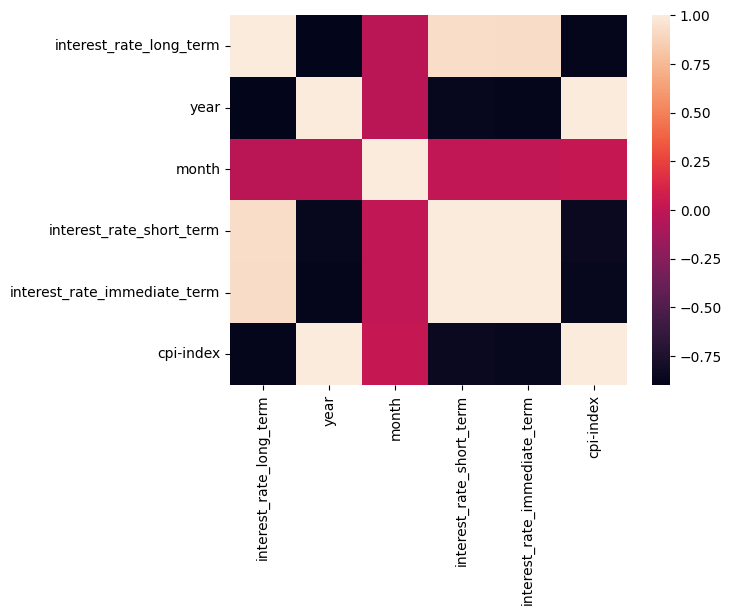

In [70]:
method='pearson'

df_au = df[df['location'] == 'AUS']

sns.heatmap(df_au.corr(numeric_only=True,method=method))
df_au.corr(numeric_only=True,method=method)

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,Cents/kWh,Lagged 1 - Cents/kWh,Lagged 2 - Cents/kWh,Lagged 3 - Cents/kWh,Lagged 4 - Cents/kWh,Lagged 5 - Cents/kWh,Lagged 6 - Cents/kWh,Lagged 7 - Cents/kWh,Lagged 8 - Cents/kWh,Lagged 9 - Cents/kWh,Lagged 10 - Cents/kWh,Lagged 11 - Cents/kWh,Lagged 12 - Cents/kWh
interest_rate_long_term,1.000000,-0.886332,-0.048246,0.763901,0.765458,-0.882816,-0.845041,-0.842552,-0.839466,-0.839077,-0.841535,-0.845828,-0.850008,-0.854864,-0.856659,-0.855034,-0.850544,-0.846994,-0.841261
year,-0.886332,1.000000,-0.026407,-0.559871,-0.562672,0.993106,0.944768,0.949415,0.952348,0.953985,0.953636,0.951380,0.948547,0.946219,0.944197,0.941923,0.939871,0.940089,0.942487
month,-0.048246,-0.026407,1.000000,-0.001141,-0.020528,0.017472,0.076835,-0.019767,-0.085403,-0.121416,-0.120451,-0.081333,-0.024549,0.034721,0.096288,0.149582,0.167022,0.155227,0.076112
interest_rate_short_term,0.763901,-0.559871,-0.001141,1.000000,0.985081,-0.549988,-0.542361,-0.541772,-0.541388,-0.540405,-0.537964,-0.534430,-0.530043,-0.525155,-0.521298,-0.518349,-0.515798,-0.514461,-0.514455
interest_rate_immediate_term,0.765458,-0.562672,-0.020528,0.985081,1.000000,-0.558519,-0.560879,-0.557702,-0.555399,-0.554756,-0.553403,-0.551362,-0.548382,-0.544637,-0.540940,-0.537816,-0.535139,-0.533013,-0.529929
cpi-index,-0.882816,0.993106,0.017472,-0.549988,-0.558519,1.000000,0.965276,0.966562,0.965568,0.963573,0.960851,0.958265,0.956710,0.957026,0.958837,0.960822,0.962531,0.964897,0.965862
Cents/kWh,-0.845041,0.944768,0.076835,-0.542361,-0.560879,0.965276,1.000000,0.990227,0.973945,0.954632,0.935030,0.921833,0.917090,0.919664,0.930450,0.946500,0.962199,0.974731,0.978027
Lagged 1 - Cents/kWh,-0.842552,0.949415,-0.019767,-0.541772,-0.557702,0.966562,0.990227,1.000000,0.990168,0.973962,0.954404,0.934856,0.921975,0.917485,0.920253,0.930575,0.945830,0.961664,0.973486
Lagged 2 - Cents/kWh,-0.839466,0.952348,-0.085403,-0.541388,-0.555399,0.965568,0.973945,0.990168,1.000000,0.990210,0.973829,0.954275,0.934906,0.922162,0.917989,0.920422,0.929863,0.945161,0.960203
Lagged 3 - Cents/kWh,-0.839077,0.953985,-0.121416,-0.540405,-0.554756,0.963573,0.954632,0.973962,0.990210,1.000000,0.990084,0.973690,0.954275,0.934993,0.922507,0.917999,0.919572,0.929280,0.943916


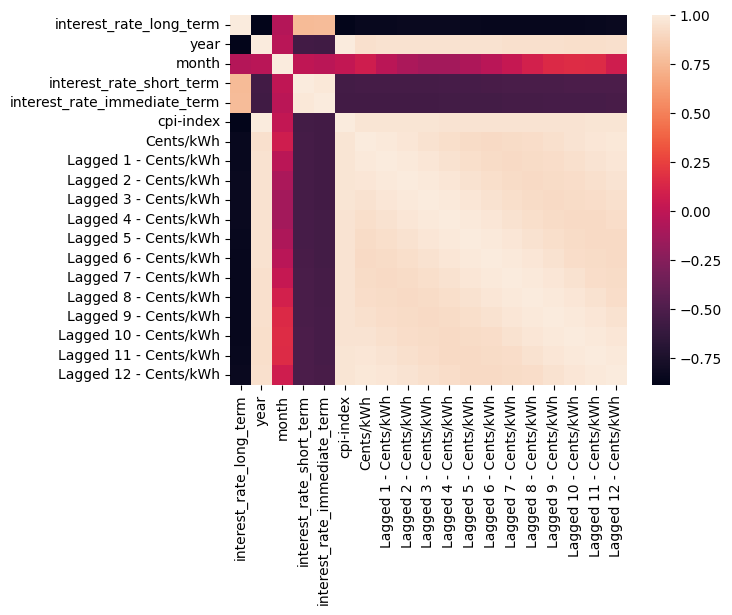

In [78]:
df_us = df[df['location'] == 'USA']

sns.heatmap(df_us.corr(numeric_only=True,method=method))
df_us.corr(numeric_only=True,method=method)

array([<AxesSubplot: xlabel='year,month'>], dtype=object)

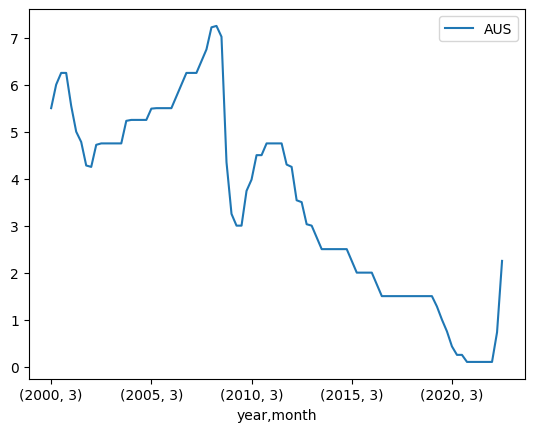

In [12]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='interest_rate_immediate_term'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>], dtype=object)

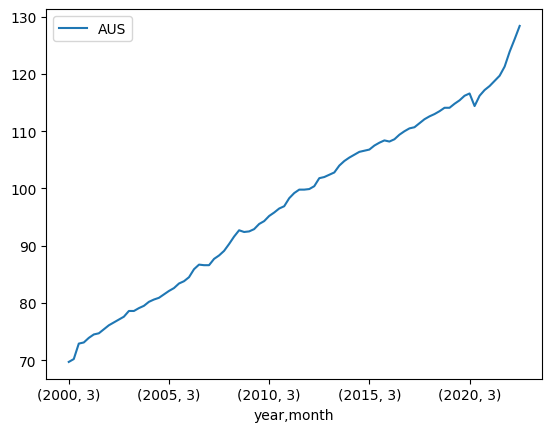

In [13]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='cpi-index'
              ).plot(subplots=True)

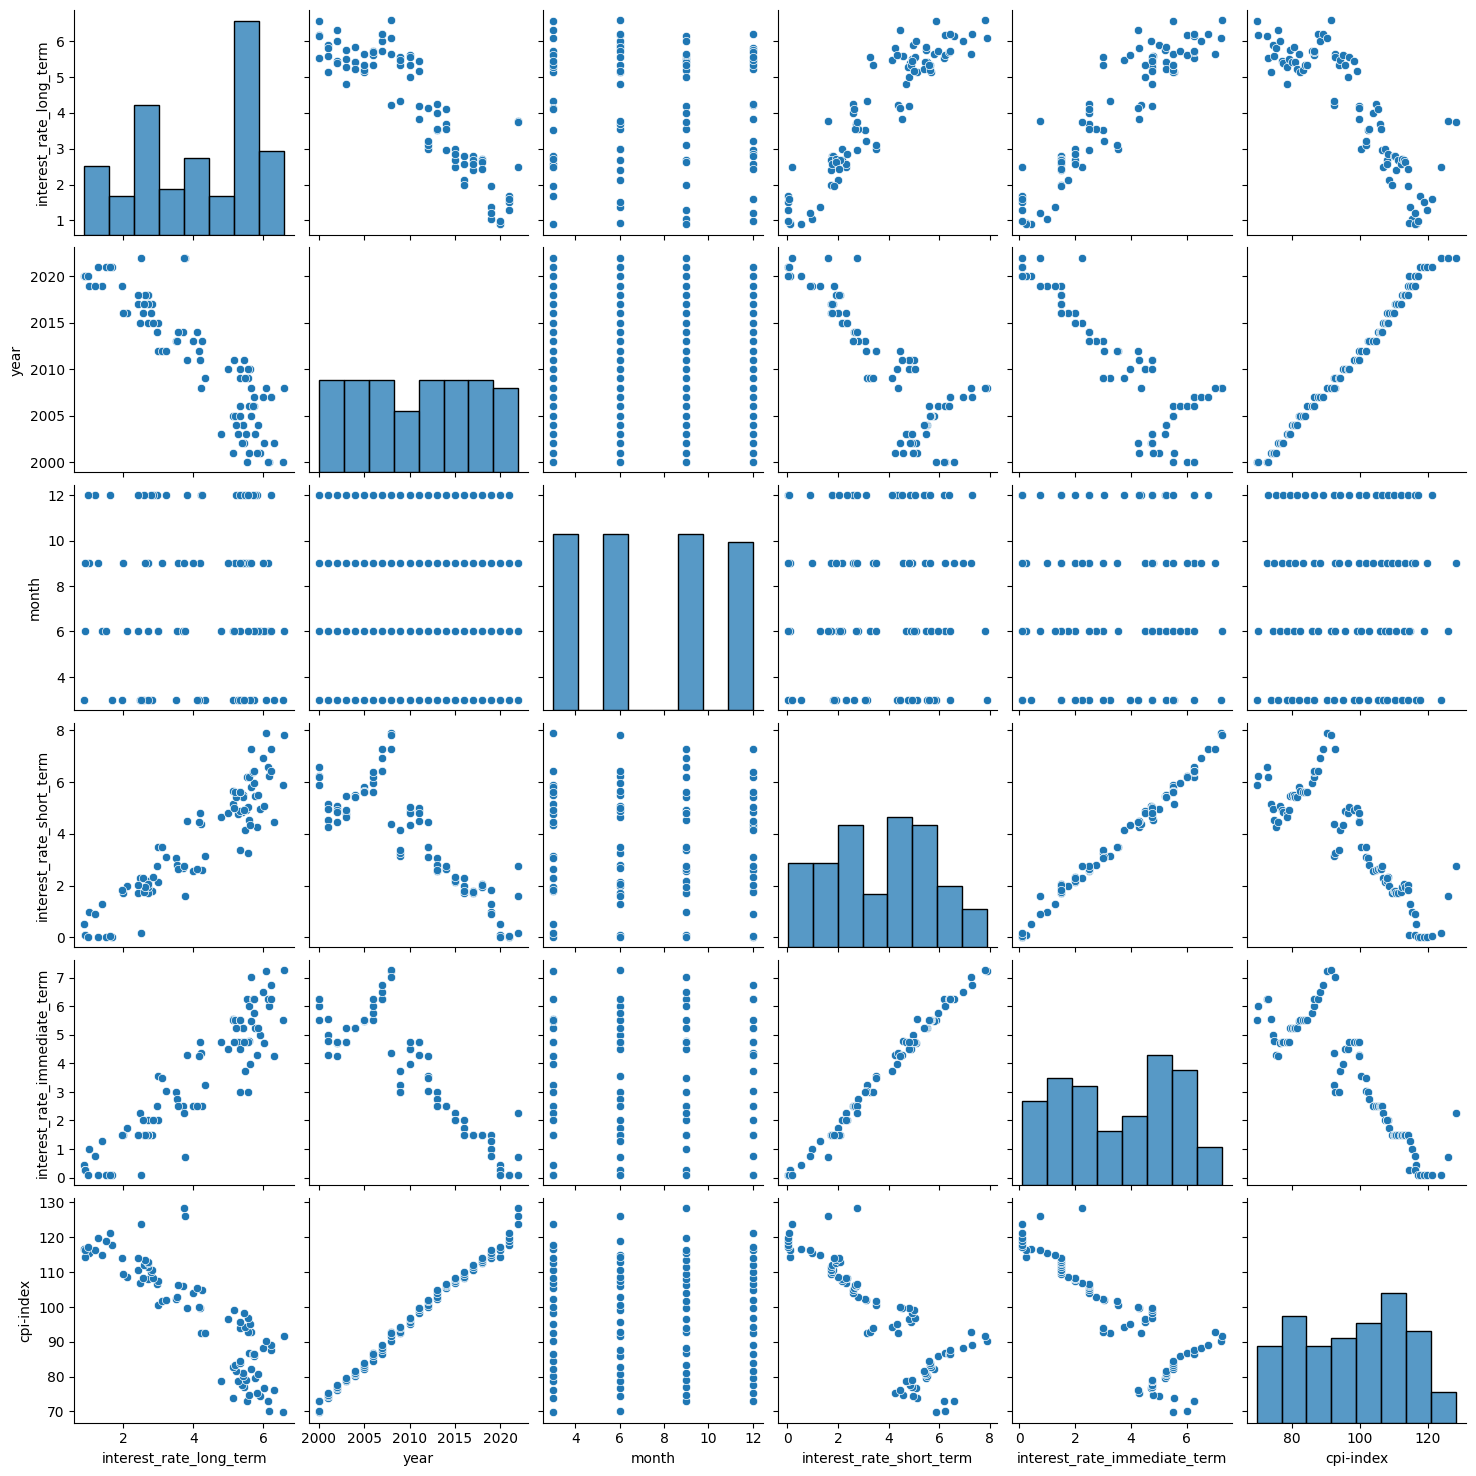

In [14]:
sns.pairplot(df)

<AxesSubplot: xlabel='location', ylabel='interest_rate_immediate_term'>

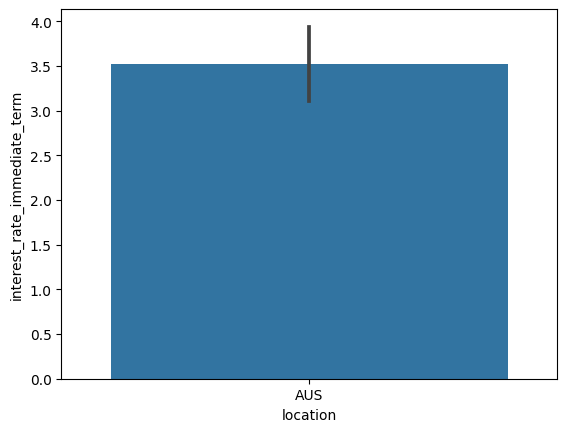

In [15]:
sns.barplot(x="location",y="interest_rate_immediate_term" , data = df)